# Basic dataset exploration

Download data from: https://www.kaggle.com/kaggle/meta-kaggle/downloads/meta-kaggle.zip/4

I put the unziped meta-kaggle data (folder called meta-kaggle) in the same folder as this script (top level of the repo). If you put the dataset somewhere else, you will need to provide an updated path.

In [ ]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import meta_kaggle_utils as utils
import numpy as np

In [2]:
# If you put the data in a different spot, change this file path.
data_location = './meta-kaggle/'

In [3]:
# other parameters
# these probably don't need to change
file_structure = "*.csv" # within data_location, what is the extension to identify the files to load
submission_file_name = 'Submissions.csv'
team_file_name = 'Teams.csv'

In [4]:
files = glob.glob(data_location + file_structure)
print('number of files found:', len(files))
print(files[0:2])

number of files found: 31
['./meta-kaggle/KernelVersionDatasetSources.csv', './meta-kaggle/UserOrganizations.csv']


## Load the submissions & teams files
- The submission files contains the information on the scores of each submission as well as who submitted them (user and team).
- The teams file contains information on the comptition, public and private leaderboard ranking, medals awarded, and the relevant submission ID

In [8]:
submissions = utils.load_kaggle_csv(data_location + submission_file_name)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (5,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


The file contains 5015235 rows.
The table contains the following columns: 
['SubmittedUserId' 'TeamId' 'SourceKernelVersionId' 'SubmissionDate'
 'ScoreDate' 'IsAfterDeadline' 'PublicScoreLeaderboardDisplay'
 'PublicScoreFullPrecision' 'PrivateScoreLeaderboardDisplay'
 'PrivateScoreFullPrecision']


In [13]:
submissions['PublicScoreFullPrecision'] = pd.to_numeric(submissions['PublicScoreFullPrecision'], errors='coerce')
submissions['PrivateScoreFullPrecision'] = pd.to_numeric(submissions['PrivateScoreFullPrecision'], errors='coerce')

In [14]:
teams = utils.load_kaggle_csv(data_location + team_file_name)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


The file contains 1740398 rows.
The table contains the following columns: 
['CompetitionId' 'TeamLeaderId' 'TeamName' 'ScoreFirstSubmittedDate'
 'LastSubmissionDate' 'PublicLeaderboardSubmissionId'
 'PrivateLeaderboardSubmissionId' 'IsBenchmark' 'Medal' 'MedalAwardDate'
 'PublicLeaderboardRank' 'PrivateLeaderboardRank']


In [15]:
# drop columns for teams that never submitted
print(teams.shape)
teams = teams.dropna(axis=0, how='any')
print(teams.shape)

(1740398, 12)
(22234, 12)


## Plotting the public scores
There is no standard scoring system for all compeitions so scores from different competitions cannot be compared. That being said it can be useful to look at the overall distribution. 
 - The median score is under 1 indicating that most competitions probably have a 0-1 with one being optimal scoring system. 
 - The max score of 212,994 indicates that at least one competition seemingly had an open ended evaluation matric.
 - The bimodal shape of the score under 2 is consistent with most competitions have a optimal score of 1 however some competition probably had an optimal score of 2.

In [16]:
public_score = submissions.PublicScoreFullPrecision[0:1000]
private_score = submissions.PrivateScoreFullPrecision[0:1000]

0.0 0.9510820209980015 683.0654802123457 212994.0


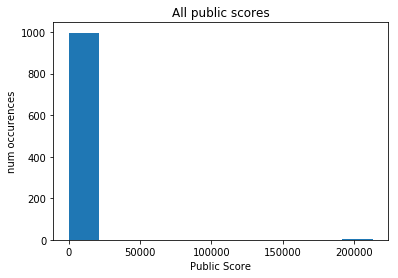

In [17]:
utils.plot_histogram(public_score, title='All public scores', xlabel='Public Score', ylabel='num occurences')
print(min(public_score), np.median(public_score), np.mean(public_score), max(public_score))

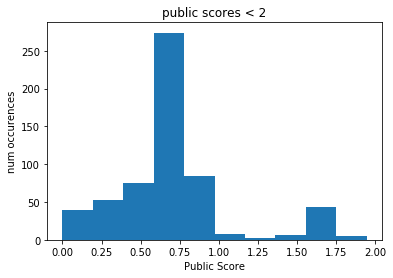

In [18]:
public_score_subset = public_score[public_score < 2]
utils.plot_histogram(public_score_subset, title='public scores < 2', xlabel='Public Score', ylabel='num occurences')

## plot the number of competitions
extract the competitions from the team database. Plot the number of entries in each competition.

In [19]:
competitions = np.unique(teams.CompetitionId)
print('there are ' + str(len(competitions)) + ' different compeitions in the dataset.')

there are 197 different compeitions in the dataset.


9 100.0 112.86294416243655 515


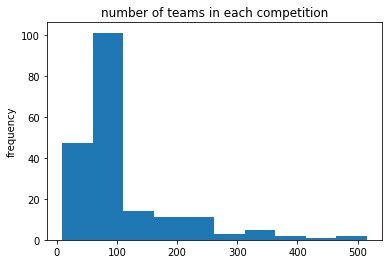

In [20]:
# how many entries per competition
competition_freq = teams.CompetitionId.value_counts()
utils.plot_histogram(competition_freq, title='number of teams in each competition')
print(min(competition_freq), np.median(competition_freq), np.mean(competition_freq), max(competition_freq))

## Add submission scores to the teams table
The teams page has the information needed to sort by competition medals or not and leaderboard rank. This will add the raw score for the submission.

To join pandas dataframes, the dataframes must have a column with the same name. I create those columns, use them to merge, then delete them.

In [21]:
# add a joining column to the submissions matrix
print(submissions.shape)
submissions['join_teams_submissions'] = submissions.index
submissions['PublicLeaderboardScore'] = submissions.PublicScoreFullPrecision
submissions['PrivateLeaderboardScore'] = submissions.PrivateScoreFullPrecision
print(submissions.shape)

(5015235, 10)
(5015235, 13)


In [22]:
# extract the column to add (and keep the joining column)
public_leaderboard = submissions[['join_teams_submissions', 'PublicLeaderboardScore']]
print(public_leaderboard.shape)
private_leaderboard = submissions[['join_teams_submissions', 'PrivateLeaderboardScore']]
print(public_leaderboard.shape)

(5015235, 2)
(5015235, 2)


In [23]:
# add the joining column to the teams matrix
print(teams.shape)
teams['join_teams_submissions'] = teams.PublicLeaderboardSubmissionId
print(teams.shape)

(22234, 12)
(22234, 13)


In [24]:
# view the matrices we are about to merge
print(public_leaderboard.head())
print(private_leaderboard.head())
print(teams.head())

      join_teams_submissions  PublicLeaderboardScore
Id                                                  
2193                    2193               56.250000
2195                    2195               53.846199
2196                    2196               52.403801
2228                    2228               51.442299
2230                    2230               52.403801
      join_teams_submissions  PrivateLeaderboardScore
Id                                                   
2193                    2193                56.791901
2195                    2195                56.647400
2196                    2196                55.780300
2228                    2228                54.624298
2230                    2230                55.346802
     CompetitionId  TeamLeaderId            TeamName ScoreFirstSubmittedDate  \
Id                                                                             
497           2435         619.0                jonp              04/30/2010   
500        

In [25]:
# perform the merge
teams_with_score = teams.join(public_leaderboard, on='join_teams_submissions', rsuffix='_j1')
teams_with_score = teams_with_score.join(private_leaderboard, on='join_teams_submissions', rsuffix='_j2')
print(teams.shape, public_leaderboard.shape, teams_with_score.shape)

# drop the columns added for joining
drop_cols = ['join_teams_submissions_j1', 'join_teams_submissions_j2', 'join_teams_submissions']
teams_with_score = teams_with_score.drop(drop_cols, axis=1)
print(teams_with_score.shape)

(22234, 13) (5015235, 2) (22234, 17)
(22234, 14)


In [26]:
# look at the output
teams_with_score

,CompetitionId,TeamLeaderId,TeamName,ScoreFirstSubmittedDate,LastSubmissionDate,PublicLeaderboardSubmissionId,PrivateLeaderboardSubmissionId,IsBenchmark,Medal,MedalAwardDate,PublicLeaderboardRank,PrivateLeaderboardRank,PublicLeaderboardScore,PrivateLeaderboardScore
Id,,,,,,,,,,,,,,
497,2435,619.0,jonp,04/30/2010,04/30/2010,2182.0,2182.0,False,3.0,07/15/2016,41.0,25.0,61.057701,65.606903
500,2435,673.0,Thylacoleo,05/02/2010,07/10/2010,2187.0,2187.0,False,3.0,07/15/2016,31.0,23.0,62.500000,65.751404
503,2435,672.0,Fontanelles,05/05/2010,05/08/2010,2199.0,2199.0,False,3.0,07/15/2016,6.0,31.0,66.346199,64.884399
504,2435,727.0,IFM_bioinformatics,05/11/2010,05/12/2010,2203.0,2246.0,False,1.0,07/15/2016,13.0,9.0,65.384598,68.208099
505,2435,728.0,Amsterdam,05/19/2010,05/19/2010,2306.0,2308.0,False,2.0,07/15/2016,18.0,11.0,64.423103,65.317902
507,2435,751.0,testingthisisme,05/07/2010,05/07/2010,2209.0,2209.0,False,3.0,07/15/2016,42.0,24.0,61.057701,65.751404
508,2435,745.0,chaos,05/07/2010,05/07/2010,2212.0,2214.0,False,1.0,07/15/2016,43.0,3.0,61.057701,65.751404
509,2435,703.0,Rajstennaj Barrabas,08/02/2010,08/02/2010,4616.0,4672.0,False,1.0,07/15/2016,1.0,4.0,99.519203,73.554901
510,2435,701.0,jtrigg,05/14/2010,05/15/2010,2283.0,2274.0,False,3.0,07/15/2016,49.0,35.0,60.576900,62.861301


In [27]:
teams_with_score['PublicLeaderboardScore'] = pd.to_numeric(teams_with_score['PublicLeaderboardScore'])
teams_with_score['PrivateLeaderboardScore'] = pd.to_numeric(teams_with_score['PrivateLeaderboardScore'])


## plot the scores for a single competition
- How correlated are the public and private leaderboards?
- for one compeition? across all competitions?

competition 2435 had 42 teams with entries
0.4914986508498049
0.7346127934303173
competition 2439 had 58 teams with entries
0.8313588033666457
0.9168762200423218
competition 2445 had 81 teams with entries
0.8848005734873744
0.8878209632613886


Text(0, 0.5, 'private ranking')

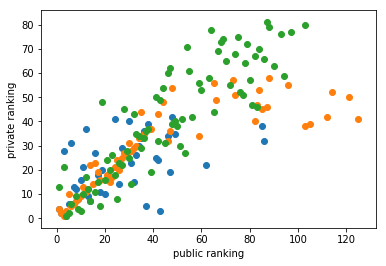

In [58]:
# TODO: make two scatter plots here, one for rank, another for score

# look at a few competitions in more depth
num = 3

# loop through to calculate
for c in competitions[0:num]:
    competition_teams = teams_with_score.loc[teams_with_score.CompetitionId == c]
    print('competition ' + str(c) + ' had ' + str(competition_teams.shape[0]) + ' teams with entries')
    
    # print the correlations
    public = competition_teams.PublicLeaderboardRank
    private = competition_teams.PrivateLeaderboardRank
    cor_rank = public.corr(private)
    plt.scatter(public.tolist(), private.tolist())
    print(cor_rank)
    cor_score = competition_teams.PublicLeaderboardScore.corr(competition_teams.PrivateLeaderboardScore)
    print(cor_score)

plt.xlabel('public ranking')
plt.ylabel('private ranking')

In [51]:
# save the correlations for each competition
cor_ranks = pd.Series(0., index=competitions)
cor_scores = pd.Series(0., index=competitions)

# loop through to calculate
for c in competitions:
    competition_teams = teams_with_score.loc[teams_with_score.CompetitionId == c]
    
    # print the correlations
    cor_ranks[c] = competition_teams.PublicLeaderboardRank.corr(competition_teams.PrivateLeaderboardRank)
    cor_scores[c] = competition_teams.PublicLeaderboardScore.corr(competition_teams.PrivateLeaderboardScore)

In [52]:
cor_rank = teams_with_score.PublicLeaderboardRank.corr(teams_with_score.PrivateLeaderboardRank)
cor_score = teams_with_score.PublicLeaderboardScore.corr(teams_with_score.PrivateLeaderboardScore)
print(str(cor_rank) + 'corelation between public and private ranking across all competitions')
print(str(cor_score) + ' corelation between public and private scores across all competitions')
print(str(np.mean(cor_ranks)) + ' corelation between public and private ranking across all competitions')
print(str(np.mean(cor_scores)) + ' corelation between public and private scores across all competitions is: ')

The corelation between public and private ranking across all competitions is: 0.5475307174487359
The corelation between public and private scores across all competitions is: 0.0026705159454029534
The corelation between public and private ranking across all competitions is: 0.7574728479992509
The corelation between public and private scores across all competitions is: 0.7177682135079837


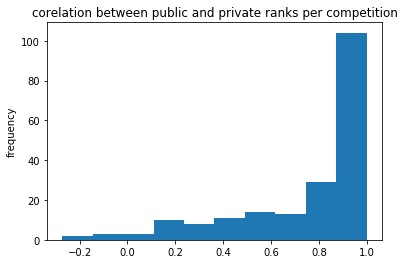

In [54]:
utils.plot_histogram(cor_ranks, title='corelation between public and private ranks per competition')

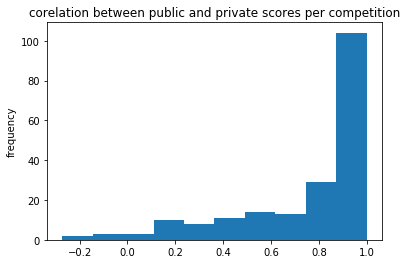

In [55]:
utils.plot_histogram(cor_ranks, title='corelation between public and private scores per competition')